In [275]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 
import requests
import numpy as np
import random 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import warnings

In [276]:
warnings.filterwarnings("ignore")

## Import the data from WHO as csv to dataframe

In [277]:
df=pd.read_csv('WHO-COVID-19-global-data_v1.csv')

In [278]:
df.shape

(20214, 8)

In [279]:
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-24T00:00:00Z,AF,Afghanistan,EMRO,1,1,0,0
1,2020-02-25T00:00:00Z,AF,Afghanistan,EMRO,0,1,0,0
2,2020-02-26T00:00:00Z,AF,Afghanistan,EMRO,0,1,0,0
3,2020-02-27T00:00:00Z,AF,Afghanistan,EMRO,0,1,0,0
4,2020-02-28T00:00:00Z,AF,Afghanistan,EMRO,0,1,0,0


In [280]:
print('There are '+ str(len(list(df['Country'].unique())))+' distinct countries')

There are 216 distinct countries


## Find the total cases per country

In [281]:
cntry_data=pd.DataFrame(df.groupby(['Country','Country_code']).max())[['Cumulative_cases','Cumulative_deaths']]

In [282]:
cntry_data.reset_index(inplace=True)
cntry_data.columns=['Country','Country_code','Total_Cases','Total_Deaths']

In [283]:
cntry_data

,Country,Country_code,Total_Cases,Total_Deaths
0,Afghanistan,AF,20342,357
1,Albania,AL,1232,34
2,Algeria,DZ,10050,698
3,Andorra,AD,852,51
4,Angola,AO,86,4
...,...,...,...,...
210,Yemen,YE,486,112
211,Zambia,ZM,1154,7
212,Zimbabwe,ZW,279,4
213,"occupied Palestinian territory, including east...",PS,643,5


In [284]:
cntry_data.dtypes

Country         object
Country_code    object
Total_Cases      int64
Total_Deaths     int64
dtype: object

## Finding the best value of K via elbow method

In [285]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cntry_data.iloc[:,2:])
    Sum_of_squared_distances.append(km.inertia_)

Sum_of_squared_distances

[4460017537315.014,
 989893392297.2336,
 294280757757.3453,
 101962017599.97691,
 54496612923.06589,
 36837086738.5309,
 24210192850.87471,
 11829938594.769316,
 7975648967.468928,
 6390924476.032951,
 4851294811.065665,
 3839768701.0121174,
 3008128879.738823,
 2308546060.568336]

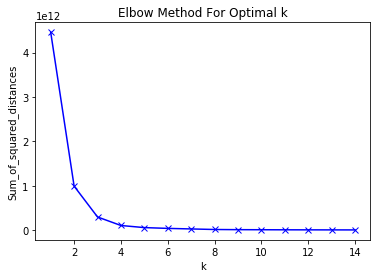

In [286]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## The optimal value of K is 4. Using that in the below to cluster countries.

In [287]:
from sklearn.cluster import KMeans
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit_predict(cntry_data.iloc[:,2:])
labels = k_means.labels_

print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3
 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [288]:
cntry_data["Labels"] = labels

In [289]:
cntry_data.head(10)

,Country,Country_code,Total_Cases,Total_Deaths,Labels
0,Afghanistan,AF,20342,357,0
1,Albania,AL,1232,34,0
2,Algeria,DZ,10050,698,0
3,Andorra,AD,852,51,0
4,Angola,AO,86,4,0
5,Anguilla,AI,3,0,0
6,Antigua and Barbuda,AG,25,3,0
7,Argentina,AR,21037,642,0
8,Armenia,AM,12364,190,0
9,Aruba,AW,101,3,0


## Reading the country capitals file to data frome, which has the country capital information and coordinates

In [290]:
country_capitals=pd.read_csv('Country_Capitals.csv')

In [291]:
country_capitals.head()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
0,Somaliland,Hargeisa,9.550000,44.050000,NaN,Africa
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000,GS,Antarctica
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667,TF,Antarctica
3,Palestine,Jerusalem,31.766667,35.233333,PS,Asia
4,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe


## Merging country corona details with country capitals data

In [292]:
cntry_data_merged = cntry_data.join(country_capitals.set_index('CountryCode'), on='Country_code')
cntry_data_merged.dropna(inplace=True)

In [293]:
cntry_cap_map=cntry_data_merged[['Country','CapitalLatitude','CapitalLongitude']]

## Visualizing the clusters using Map

In [294]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cntry_data_merged['CapitalLatitude'], cntry_data_merged['CapitalLongitude'], cntry_data_merged['Country'], cntry_data_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyzing clusters based on Covid-19 cases

In [319]:
cntry_data[cntry_data['Labels'] == 0]

,Country,Country_code,Total_Cases,Total_Deaths,Labels
0,Afghanistan,AF,20342,357,0
1,Albania,AL,1232,34,0
2,Algeria,DZ,10050,698,0
3,Andorra,AD,852,51,0
4,Angola,AO,86,4,0
...,...,...,...,...,...
210,Yemen,YE,486,112,0
211,Zambia,ZM,1154,7,0
212,Zimbabwe,ZW,279,4,0
213,"occupied Palestinian territory, including east...",PS,643,5,0


In [320]:
cntry_data[cntry_data['Labels'] == 1]

,Country,Country_code,Total_Cases,Total_Deaths,Labels
205,United States of America,US,1886794,109038,1


In [321]:
cntry_data[cntry_data['Labels'] == 2]

,Country,Country_code,Total_Cases,Total_Deaths,Labels
27,Brazil,BR,614941,34021,2
161,Russian Federation,RU,458689,5725,2


In [322]:
cntry_data[cntry_data['Labels'] == 3]

,Country,Country_code,Total_Cases,Total_Deaths,Labels
36,Canada,CA,94335,7703,3
40,Chile,CL,127745,1541,3
69,France,FR,149495,29053,3
75,Germany,DE,183678,8646,3
93,India,IN,246628,6929,3
95,Iran (Islamic Republic of),IR,169425,8209,3
100,Italy,IT,234531,33774,3
129,Mexico,MX,110026,13170,3
148,Pakistan,PK,98943,2002,3
152,Peru,PE,187400,5162,3


## Defining Four Square API parameters

In [242]:
CLIENT_ID = 'BOXBUAVI1X5TFDF2UYFNAHZTDT0QNKVI3WSCK52HSQABZTOX' # your Foursquare ID
CLIENT_SECRET = 'WPI1XG0SDRFOULXOTJ0T2YUC2MVLFYNWA4DZRKOLEDZ0XTW4' # your Foursquare Secret
VERSION = '20200504'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 1000

Your credentails:
CLIENT_ID: BOXBUAVI1X5TFDF2UYFNAHZTDT0QNKVI3WSCK52HSQABZTOX
CLIENT_SECRET:WPI1XG0SDRFOULXOTJ0T2YUC2MVLFYNWA4DZRKOLEDZ0XTW4


## Creating function to get the capital and latitude, longitude 

In [295]:
def getLocationCoordinates(Country_Code):
    capital=country_capitals.loc[country_capitals['CountryCode']==Country_Code,'CapitalName'].values[0]
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(capital)
    latitude = location.latitude
    longitude = location.longitude
    return(capital, latitude, longitude)

In [296]:
top_countries=cntry_data.sort_values(by='Total_Cases',ascending=False).head(100)
top_countries.reset_index(inplace=True, drop=True)

In [297]:
top_countries

,Country,Country_code,Total_Cases,Total_Deaths,Labels
0,United States of America,US,1886794,109038,1
1,Brazil,BR,614941,34021,2
2,Russian Federation,RU,458689,5725,2
3,The United Kingdom,GB,283315,40261,3
4,India,IN,246628,6929,3
...,...,...,...,...,...
95,Kyrgyzstan,KG,1974,22,0
96,Ethiopia,ET,1934,20,0
97,Estonia,EE,1910,69,0
98,Maldives,MV,1901,8,0


## Finding out the popular venues in the country capitals of first 100 countries with most Corona cases

In [298]:
capital_venues=pd.DataFrame()

In [299]:
capital_venues

""


In [300]:
for i, row in top_countries.iterrows():
    try:
        capital, lat, long=getLocationCoordinates(row['Country_code'])
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                long, 
                radius, 
                LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
    except:
        print("Exception occurred for "+row['Country_code'])
        
    venues_list=[]
    venues_list.append([(
            row['Country'], 
            capital, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    capital_venues=capital_venues.append(nearby_venues,ignore_index=True)
    

Exception occurred for PL
Exception occurred for DO
Exception occurred for KE
Exception occurred for YT


In [301]:
capital_venues.columns=['Country','capital','Venue','Venue Category']

In [302]:
capital_venues

,Country,capital,Venue,Venue Category
0,United States of America,Washington,South Lawn,Garden
1,United States of America,Washington,The White House,Government Building
2,United States of America,Washington,The West Wing,Government Building
3,United States of America,Washington,Old Ebbitt Grill,American Restaurant
4,United States of America,Washington,The Willard InterContinental Washington D.C. H...,Hotel
...,...,...,...,...
6573,Sri Lanka,Colombo,Pettah Central Bus Station,Bus Station
6574,Sri Lanka,Colombo,China Street,Flea Market
6575,Sri Lanka,Colombo,Devi Jewellers,Jewelry Store
6576,Sri Lanka,Colombo,Vj City Hotel,Hotel


In [303]:
capital_venues.groupby('Country').count()

,capital,Venue,Venue Category
Country,,,
Afghanistan,8,8,8
Algeria,19,19,19
Argentina,100,100,100
Armenia,100,100,100
Australia,4,4,4
...,...,...,...
Ukraine,100,100,100
United Arab Emirates,100,100,100
United States of America,100,100,100


In [304]:
print('There are {} uniques categories.'.format(len(capital_venues['Venue Category'].unique())))

There are 433 uniques categories.


In [305]:
# one hot encoding
country_onehot = pd.get_dummies(capital_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
country_onehot['Country'] = capital_venues['Country'] 



In [306]:
# move neighborhood column to the first column
fixed_columns = [country_onehot.columns[-1]] + list(country_onehot.columns[:-1])
country_onehot = country_onehot[fixed_columns]

country_onehot.head()

,Country,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo Exhibit
0,United States of America,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,United States of America,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,United States of America,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,United States of America,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,United States of America,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [307]:
country_grouped = country_onehot.groupby('Country').mean().reset_index()
country_grouped

,Country,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo Exhibit
0,Afghanistan,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,Algeria,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,Argentina,0.0,0.00,0.01,0.0,0.0,0.0,0.00,0.01,0.0,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,Armenia,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0
4,Australia,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Ukraine,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.0,0.0
92,United Arab Emirates,0.0,0.00,0.02,0.0,0.0,0.0,0.02,0.00,0.0,...,0.01,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
93,United States of America,0.0,0.00,0.00,0.0,0.0,0.0,0.03,0.00,0.0,...,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0
94,Uzbekistan,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.0,0.0


## Display the 10 most common venues in a country

In [308]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [309]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Country']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
country_venues_sorted = pd.DataFrame(columns=columns)
country_venues_sorted['Country'] = country_grouped['Country']

for ind in np.arange(country_grouped.shape[0]):
    country_venues_sorted.iloc[ind, 1:] = return_most_common_venues(country_grouped.iloc[ind, :], num_top_venues)

country_venues_sorted.head()

,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Afghanistan,Shopping Mall,Hotel,Supermarket,French Restaurant,Pizza Place,Big Box Store,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farmers Market
1,Algeria,Hotel,Café,Restaurant,Harbor / Marina,BBQ Joint,Lounge,Art Museum,Theater,Plaza,Italian Restaurant
2,Argentina,Argentinian Restaurant,Bakery,Ice Cream Shop,Café,Pizza Place,Gym,Burger Joint,Italian Restaurant,Empanada Restaurant,Restaurant
3,Armenia,Restaurant,Hotel,Café,Fast Food Restaurant,Bakery,Art Gallery,Plaza,Coffee Shop,Italian Restaurant,Brewery
4,Australia,Garden Center,Restaurant,Park,Beach,Gaming Cafe,Furniture / Home Store,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant


## Find out the appropriate K using elbow method

In [310]:
country_grouped_clustering = country_grouped.drop('Country', 1)

In [311]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(country_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

Sum_of_squared_distances

[7.60412330821468,
 6.716539399286498,
 6.210946245072316,
 5.7371433032449675,
 5.477237206994431,
 5.087385580074898,
 4.73444784844505,
 4.327284359822987,
 4.027009565195435,
 3.806510598766619,
 3.628876746082722,
 3.493910266579768,
 3.1982627072746697,
 3.0194316199375733,
 2.760392012995013,
 2.684853900193764,
 2.590088895795015,
 2.337811051037439,
 2.321185752105488]

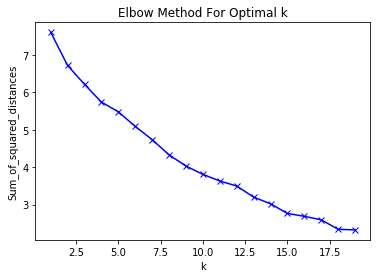

In [312]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## The optimal value of K is 11. Using that in the below to cluster countries.

In [313]:
# set number of clusters
kclusters = 11

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(country_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([ 2,  0,  0,  0,  9,  0,  0,  0,  9,  9,  9,  0,  0,  5,  9,  8,  9,
        0,  0,  0,  0,  1,  5,  9,  9,  9,  0,  0,  9,  2,  9,  9,  5,  9,
        9,  0,  9, 10,  6,  0,  9,  6,  9,  0,  4,  0,  0,  9,  0,  9,  0,
        0,  9,  9,  9,  9,  9,  0,  9,  9,  0,  0,  9,  0,  6,  0,  9,  9,
        9,  0,  9,  0,  9,  0,  9,  9,  9,  7,  0,  0,  3,  0,  0,  9,  0,
        9,  0,  9,  0,  9,  0,  9,  0,  9,  9,  9], dtype=int32)

In [314]:
# add clustering labels
country_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [315]:
country_venues_sorted

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Afghanistan,Shopping Mall,Hotel,Supermarket,French Restaurant,Pizza Place,Big Box Store,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farmers Market
1,0,Algeria,Hotel,Café,Restaurant,Harbor / Marina,BBQ Joint,Lounge,Art Museum,Theater,Plaza,Italian Restaurant
2,0,Argentina,Argentinian Restaurant,Bakery,Ice Cream Shop,Café,Pizza Place,Gym,Burger Joint,Italian Restaurant,Empanada Restaurant,Restaurant
3,0,Armenia,Restaurant,Hotel,Café,Fast Food Restaurant,Bakery,Art Gallery,Plaza,Coffee Shop,Italian Restaurant,Brewery
4,9,Australia,Garden Center,Restaurant,Park,Beach,Gaming Cafe,Furniture / Home Store,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
91,9,Ukraine,Coffee Shop,Plaza,Boutique,Park,Café,Theater,Cocktail Bar,Gift Shop,Scenic Lookout,Bakery
92,0,United Arab Emirates,Middle Eastern Restaurant,Hotel,Café,Indian Restaurant,Filipino Restaurant,Coffee Shop,Restaurant,Gym,Fast Food Restaurant,Dessert Shop
93,9,United States of America,Hotel,Coffee Shop,History Museum,Monument / Landmark,Garden,Steakhouse,Exhibit,Park,Art Museum,Sandwich Place
94,9,Uzbekistan,Coffee Shop,Hotel,Fast Food Restaurant,Pizza Place,Café,Comfort Food Restaurant,Flower Shop,Plaza,Japanese Restaurant,Bakery


In [316]:
cntry_venues_data_merged = country_venues_sorted.join(cntry_cap_map.set_index('Country'), on='Country')
cntry_venues_data_merged.dropna(inplace=True)

## Visualising similiar clusters using Map

In [317]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cntry_venues_data_merged['CapitalLatitude'], cntry_venues_data_merged['CapitalLongitude'], cntry_venues_data_merged['Country'], cntry_venues_data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyzing clusters based on common venues

In [323]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==0]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,Algeria,Hotel,Café,Restaurant,Harbor / Marina,BBQ Joint,Lounge,Art Museum,Theater,Plaza,Italian Restaurant
2,0,Argentina,Argentinian Restaurant,Bakery,Ice Cream Shop,Café,Pizza Place,Gym,Burger Joint,Italian Restaurant,Empanada Restaurant,Restaurant
3,0,Armenia,Restaurant,Hotel,Café,Fast Food Restaurant,Bakery,Art Gallery,Plaza,Coffee Shop,Italian Restaurant,Brewery
5,0,Austria,Hotel,Restaurant,Plaza,Austrian Restaurant,Italian Restaurant,Café,Bar,Ice Cream Shop,Supermarket,Cocktail Bar
6,0,Azerbaijan,Café,Coffee Shop,Restaurant,Park,Hotel,Italian Restaurant,French Restaurant,Steakhouse,Pub,Diner
7,0,Bahrain,Café,Indian Restaurant,Middle Eastern Restaurant,Coffee Shop,Hookah Bar,Thai Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Boutique,Asian Restaurant
11,0,Bolivia (Plurinational State of),Hostel,Hotel,Plaza,Café,Vegetarian / Vegan Restaurant,Italian Restaurant,Museum,Coffee Shop,Pub,Fried Chicken Joint
12,0,Bosnia and Herzegovina,Restaurant,Café,Pub,Italian Restaurant,Hotel,Hookah Bar,Big Box Store,French Restaurant,Toy / Game Store,Breakfast Spot
17,0,Colombia,Café,Restaurant,History Museum,Italian Restaurant,Mexican Restaurant,Hotel,Cocktail Bar,Coffee Shop,Breakfast Spot,Bookstore
18,0,Croatia,Café,Bar,Plaza,Bistro,Theater,Mediterranean Restaurant,Dessert Shop,Wine Bar,Park,Pedestrian Plaza


In [324]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==1]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,1,Côte d’Ivoire,Train Station,Bus Station,Diner,Zoo Exhibit,Food Truck,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


In [325]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==2]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Afghanistan,Shopping Mall,Hotel,Supermarket,French Restaurant,Pizza Place,Big Box Store,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farmers Market
29,2,Ethiopia,Hotel,History Museum,Ethiopian Restaurant,Café,Soccer Stadium,Shopping Mall,Bar,Gym,Plaza,Spa


In [326]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==3]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,3,Somalia,Hotel,Zoo Exhibit,Food & Drink Shop,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


In [327]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==4]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,4,Iraq,Bar,Clothing Store,Zoo Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


In [328]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==5]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,5,Cameroon,Bakery,Hotel,Bar,Nightclub,Food & Drink Shop,Comedy Club,Lounge,Platform,Café,Market
22,5,Democratic Republic of the Congo,Mobile Phone Shop,Resort,Bakery,Food & Drink Shop,Fabric Shop,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
32,5,Gabon,Bakery,Convenience Store,Beach,Zoo Exhibit,Food Court,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [329]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==6]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,6,Haiti,History Museum,Buffet,Park,Fast Food Restaurant,Hotel,Bus Station,Flea Market,Farmers Market,Filipino Restaurant,Fish & Chips Shop
41,6,India,Smoke Shop,Museum,Tea Room,Music Venue,Spiritual Center,Garden,Design Studio,Dance Studio,Filipino Restaurant,Fish & Chips Shop
64,6,Pakistan,History Museum,Market,National Park,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


In [330]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==7]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,7,Senegal,Park,African Restaurant,Plaza,Market,Zoo Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


In [331]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==8]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,8,Chile,Football Stadium,Bus Station,Food Truck,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market


In [332]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==9]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,9,Australia,Garden Center,Restaurant,Park,Beach,Gaming Cafe,Furniture / Home Store,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant
8,9,Bangladesh,Asian Restaurant,Shopping Mall,Indian Restaurant,Café,Park,Chinese Restaurant,Plaza,Fried Chicken Joint,Pharmacy,Bakery
9,9,Belarus,Cocktail Bar,Restaurant,Coffee Shop,Bar,Café,French Restaurant,Arts & Crafts Store,Park,Wine Bar,Flower Shop
10,9,Belgium,Chocolate Shop,Bar,Bookstore,Plaza,Bakery,Coffee Shop,French Restaurant,Sandwich Place,Seafood Restaurant,Beer Bar
14,9,Canada,Coffee Shop,Hotel,Café,Tapas Restaurant,Italian Restaurant,Restaurant,Concert Hall,Museum,Park,Taco Place
16,9,China,Historic Site,Hotel,History Museum,Park,Monument / Landmark,Fast Food Restaurant,Metro Station,Museum,Scenic Lookout,Plaza
23,9,Denmark,Café,Beer Bar,Coffee Shop,Scandinavian Restaurant,Bakery,Cocktail Bar,French Restaurant,Restaurant,Wine Bar,Park
24,9,Dominican Republic,Coffee Shop,Hotel,Cocktail Bar,Gym / Fitness Center,Bookstore,Gastropub,Restaurant,Pizza Place,Wine Bar,Ice Cream Shop
25,9,Ecuador,Restaurant,Hotel,Plaza,Church,History Museum,Diner,Coffee Shop,Shopping Mall,Historic Site,Park
28,9,Estonia,Restaurant,Scenic Lookout,Hotel,Café,Coffee Shop,Eastern European Restaurant,Cocktail Bar,Park,Wine Bar,Theme Restaurant


In [333]:
country_venues_sorted[country_venues_sorted['Cluster Labels']==10]

,Cluster Labels,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,10,Guinea,Nightclub,Hotel,Italian Restaurant,Beach,Zoo Exhibit,Food & Drink Shop,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant
